# Data retrieval

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [4]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [5]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,OnePlus records highest-ever sales in Q318 wit...,"According to the IDC Q3 2018 Quarterly report,...",technology
1,OnePlus 6T Thunder Purple variant now availabl...,The new Thunder Purple variant of the OnePlus ...,technology
2,"Actor Jim Carrey criticises Zuckerberg, tweets...",American-Canadian actor Jim Carrey has critici...,technology
3,Instagram bug exposes passwords of some users,A bug on Facebook-owned photo-sharing app Inst...,technology
4,Zuckerberg asks staff not to use iPhones post ...,Facebook CEO Mark Zuckerberg ordered his manag...,technology
5,"Twitter CEO shares South Indian food menu, say...","Twitter CEO Jack Dorsey, who was on his maiden...",technology
6,"Kanye, Zuckerberg sing Backstreet Boys during ...",American rapper Kanye West on Wednesday took t...,technology
7,"One day Amazon will fail, go bankrupt: CEO Jef...",Amazon CEO Jeff Bezos reportedly told employee...,technology
8,Kerala-born former Oracle product chief named ...,Google has announced that Kerala-born former O...,technology
9,Mark Zuckerberg lost $31 billion in wealth sin...,American social networking giant Facebook's Co...,technology


In [4]:
news_df.news_category.value_counts()

sports        25
technology    25
world         25
Name: news_category, dtype: int64

# Text Wrangling and Pre-processing

In [8]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Remove HTML tags

In [9]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Remove accented characters

In [10]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

In [11]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

## Remove special characters

In [12]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Text lemmatization

In [13]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

## Text stemming

In [14]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Remove stopwords

In [15]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

In [16]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

In [17]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [18]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'apple ceo tim cook deliver newspaper teen st job world valuable company apple ceo tim cook first job deliver newspaper teenager use deliver newspaper press register publication home state alabama cook complete seven year apple ceo today also work part time mother local pharmacy',
 'full_text': "Apple CEO Tim Cook delivered newspapers as a teen in 1st job. World's most valuable company Apple's CEO Tim Cook's first job was delivering newspapers as a teenager. He used to deliver the newspaper 'Press-Register', a publication from his home state of Alabama. Cook, who completes seven years as Apple CEO today, had also worked part-time with his mother at a local pharmacy."}

# Save the news articles

In [19]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech

In [20]:
news_df = pd.read_csv('news.csv')

In [21]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [22]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Apple,NNP,PROPN
1,CEO,NNP,PROPN
2,Tim,NNP,PROPN
3,Cook,NNP,PROPN
4,delivered,VBD,VERB
5,newspapers,NNS,NOUN
6,as,IN,ADP
7,a,DT,DET
8,teen,NN,NOUN
9,in,IN,ADP


In [23]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Apple,NNP
1,CEO,NNP
2,Tim,NNP
3,Cook,NNP
4,delivered,VBD
5,newspapers,NNS
6,as,IN
7,a,DT
8,teen,NN
9,in,IN


# Shallow Parsing or Chunking Text

In [24]:
from nltk.corpus import conll2000
data = conll2000.chunked_sents()

train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [25]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [26]:
tree = conlltags2tree(wtc) 
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [27]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [28]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [29]:
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [30]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Apple/NNP CEO/NNP Tim/NNP Cook/NNP)
  (VP delivered/VBD)
  (NP newspapers/NNS)
  (PP as/IN)
  (NP a/DT teen/NN)
  (PP in/IN)
  (NP 1st/CD job/NN))


# Dependency parsing

In [34]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Apple[compound]--->[]
--------
['Apple']<---CEO[compound]--->[]
--------
[]<---Tim[compound]--->[]
--------
['CEO', 'Tim']<---Cook[nsubj]--->[]
--------
['Cook']<---delivered[ROOT]--->['newspapers', 'as', 'in']
--------
[]<---newspapers[dobj]--->[]
--------
[]<---as[prep]--->['teen']
--------
[]<---a[det]--->[]
--------
['a']<---teen[pobj]--->[]
--------
[]<---in[prep]--->['job']
--------
[]<---1st[amod]--->[]
--------
['1st']<---job[pobj]--->[]
--------


In [35]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

# Named Entity Recognition

In [39]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

In [40]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(Apple, 'ORG'), (Tim, 'PERSON'), (Cook, 'PERSON'), (1st, 'DATE'), (World, 'ORG'), (Apple, 'ORG'), (Tim, 'PERSON'), (Cook, 'PERSON'), ('s, 'PERSON'), (first, 'ORDINAL'), (', 'ORG'), (Press, 'ORG'), (-, 'ORG'), (Register, 'ORG'), (', 'ORG'), (Alabama, 'GPE'), (Cook, 'PERSON'), (seven, 'DATE'), (years, 'DATE'), (Apple, 'ORG'), (today, 'DATE')]


In [41]:
displacy.render(sentence_nlp, style='ent', jupyter=True)

In [42]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [43]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,Indian,Apple,first,Google,India,China,WhatsApp,Facebook,Iran,Asiad,two,Asian,second,Instagram
Entity Type,GPE,NORP,ORG,ORDINAL,ORG,GPE,GPE,ORG,ORG,GPE,GPE,CARDINAL,NORP,ORDINAL,GPE
Frequency,19,14,10,10,10,9,8,8,8,6,6,6,5,4,4


In [44]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,GPE,PERSON,DATE,NORP,CARDINAL,ORDINAL,PRODUCT,TIME,MONEY,EVENT,LOC,PERCENT,QUANTITY,FAC
Frequency,162,125,121,86,70,61,23,11,9,9,9,8,7,6,2


In [47]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,US,GPE,19
1,Indian,NORP,14
2,Apple,ORG,10
3,first,ORDINAL,10
4,Google,ORG,10
5,India,GPE,9
6,China,GPE,8
7,WhatsApp,ORG,8
8,Facebook,ORG,8
9,Iran,GPE,6


In [48]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,ORG,162
1,GPE,125
2,PERSON,121
3,DATE,86
4,NORP,70


# Emotion and Sentiment Analysis

In [50]:
from afinn import Afinn

af = Afinn()

In [51]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [52]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                            
                        count  mean       std   min  25%  50%   75%   max
news_category                                                            
sports                   25.0  5.36  8.014986 -10.0  1.0  4.0  10.0  23.0
technology               25.0  0.44  3.559963  -7.0 -2.0  0.0   3.0   8.0
world                    25.0 -4.36  5.894065 -17.0 -8.0 -3.0   1.0   4.0

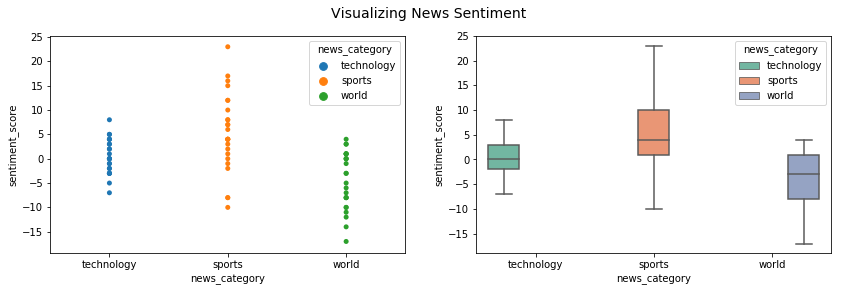

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

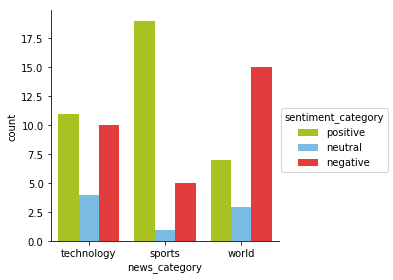

In [54]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [58]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 1)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -1)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Google parent Alphabet's self-driving unit Waymo has set up a subsidiary named Huimo Business Consulting in Shanghai, China. Waymo had set up the unit in May, in Shanghai’s free trade zone with registered capital of 3.5 million yuan. This comes amidst Google's efforts to build a presence in the country after it quit China’s search engine market in 2010. 

Most Positive Tech News Article: WhatsApp is reportedly looking to open up its first India office in Hyderabad after CEO Chris Daniels met Telangana IT minister KT Rama Rao on Thursday. This comes after WhatsApp agreed to meet all demands by the central government except tracing the origin of messages. Facebook, which owns WhatsApp, had launched its Asia hub in Hyderabad in 2010.


In [60]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 1)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -1)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: The US State Department on Friday announced it had cancelled over $200 million in aid for Palestinians in the West Bank and Gaza Strip. The US had earlier this year withheld an aid of $65 million to UNRWA, the UN agency for Palestinian refugees. Relations between Palestine and the US have become strained after it recognised Jerusalem as Israel's capital. 

Most Positive World News Article: Pakistan's newly-appointed Foreign Minister Shah Mahmood Qureshi on Friday said that a dialogue was essential for improving relations with India, adding that "it takes two to tango". He stated that Pakistan is not shy of engagement and recalled PM Imran Khan's first address wherein the former cricketer had said, "You take one step, we will take two."


In [61]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [62]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
sports                   25.0  0.19696  0.198077 -0.183  0.083  0.181  0.333   
technology               25.0  0.01372  0.179996 -0.467 -0.081  0.000  0.113   
world                    25.0  0.02036  0.108477 -0.142 -0.033  0.000  0.050   

                      
                 max  
news_category         
sports         0.700  
technology     0.300  
world          0.375

In [63]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,0.100,positive
1,technology,0.087,positive
2,technology,0.293,positive
3,technology,0.113,positive
4,technology,0.000,neutral


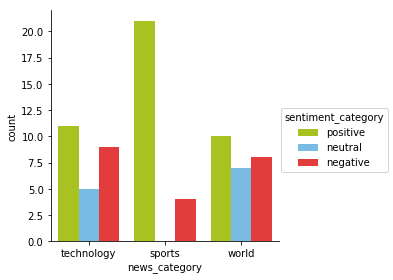

In [64]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [69]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == 0)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Kerala Chief Minister Pinarayi Vijayan has said that there is no confusion over UAE's aid for Kerala, as UAE ruler made the offer to PM Narendra Modi. He also asked people to read PM's tweet. PM Modi had thanked the UAE for a "gracious offer" after the country's Prime Minister tweeted that the UAE will offer relief to those affected.

Most Positive World News Article: Kerala Chief Minister Pinarayi Vijayan has said that there is no confusion over UAE's aid for Kerala, as UAE ruler made the offer to PM Narendra Modi. He also asked people to read PM's tweet. PM Modi had thanked the UAE for a "gracious offer" after the country's Prime Minister tweeted that the UAE will offer relief to those affected.


In [70]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

Predicted:                 
                   negative neutral positive
Actual: negative         15       7        8
        neutral           2       2        4
        positive          4       3       30